# Temple Artifact Removal Tool Validation

This notebook imports the artifact data from the Temple dataset. The dataset is imported and separated into `clean`, `eye`, and `mus` files; where `clean` is the clean data from the beginning of the trial, `eye` are the eye movement artifacts, and `mus` are the muscle artifacts, respectively. 

The dataset is then preprocessed, run through the artifact removal tool, and the EEG Quality Index is calculated. 

Notes
-----
- This notebook requires the `.npz` files exported from the [Import datasets](./01_Import_datasets.ipynb) notebook.
- Run each section of the notebook **separately**. Each section of code has some `settings` associated with the individual section.

In [3]:
#%% Import standard libraries
import os
import mne
import sys
import time
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.collections as collections

#%% Import custom libraries
sys.path.append("..") # Adds higher directory to python modules path.
from Functions import artifact_removal_tools as art
from Functions import eeg_preprocessing
from Functions import eeg_quality_index
from IPython.display import clear_output

# Import and segment data

- The `.npz` files are imported.
- The `eye` and `mus` variables are segmented in lists containing the individual artifacts

In [4]:
## Import data
notebook_dir = os.getcwd()              # Notebook directory
os.chdir('..')                          # Move one folder up
main_dir = os.getcwd()                  # Main project directory
data_folder = main_dir + "\\Data"       # Data folder
all_files = os.listdir(path=data_folder)# List of subjects
os.chdir(notebook_dir)                  # Return to notebook directory

# - Select only .edf files and remove file extension
edf_files = [file.split('.')[0] for file in all_files if file.split('.')[-1] =='edf']

## Preallocate variables
n_files = len(edf_files)        # Number of files
clean_eeg = [None] * n_files    # Clean segment of EEG data [V] [n_channels x samples]
eye_eeg = [None] * n_files      # 
mus_eeg = [None] * n_files
srate = [None] * n_files
chans = [None] * n_files

## Select valid EEG channels
# - List of valid EEG channels to separate them from other types of data
eeg_valid_chans = np.array(['FP1','FP2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8',
                    'T3','T4','T5','T6','T1','T2','FZ','CZ','PZ'])

# - Select only the valid channels from each file
for f,file in enumerate(edf_files):
    # Load temporary data
    temp_file_name = data_folder + '\\' + file + '.npz'
    temp_data = np.load(temp_file_name, allow_pickle=True)
    
    # Get index of valid EEG channels
    chans[f] = temp_data['chans']   # List of all channels
    eeg_idx = np.zeros(np.size(eeg_valid_chans), dtype=int) # Temporary index for channels
    print(f'{file} file loaded')

    for ci,c in enumerate(eeg_valid_chans): # For channel_index in channel
        if np.size(np.where(chans[f]==c)) > 0:
            eeg_idx[ci] = (np.where(chans[f]==c)[0])

    eeg_idx = np.sort(eeg_idx)      # Sort list of channels
    chans[f] = chans[f][eeg_idx]    # Select only valid channels
    
    # Organize eye and muscle artifacts in tensors
    eye_artifacts = np.size(temp_data['eye_eeg'])
    eye_eeg[f] = [None] * eye_artifacts
    for eye in range(eye_artifacts):
        eye_eeg[f][eye] = temp_data['eye_eeg'][eye][eeg_idx,:]

    mus_artifacts = np.size(temp_data['mus_eeg'])
    mus_eeg[f] = [None] * mus_artifacts
    for mus in range(mus_artifacts):
        mus_eeg[f][mus] = temp_data['mus_eeg'][mus][eeg_idx,:]

    # Separate clean EEG and sampling rate
    clean_eeg[f] = temp_data['clean_eeg'][eeg_idx,:]    
    srate[f] = temp_data['srate']
    
    del temp_data   # Delete temporary data from memory

00000254_s007_t000 file loaded
00000647_s002_t000 file loaded
00000768_s003_t000 file loaded


# Pre-process

Apply band-pass filter datasets. Plot filtered data if needed.

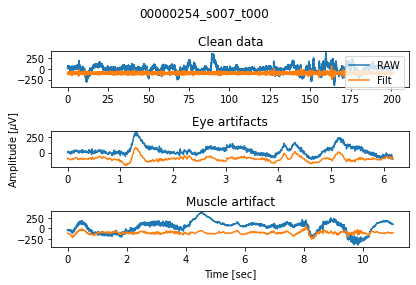

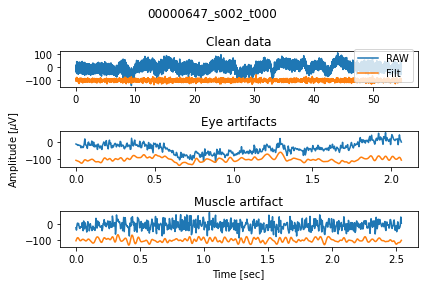

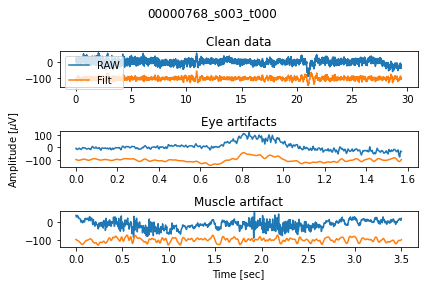

In [5]:
#%% Settings
# - Plot settings
plot_filtered = True
scale = 1e6
offset = 100

# - Filter settings
fc = [1, 30]    # Cut-off frequencies [Hz]
f_type = "band" # Filter type
f_order = 4     # Filter order [n]

#%% Preallocate data
clean_pre_eeg = [None] * n_files
mus_pre_eeg =   [None] * n_files
eye_pre_eeg =   [None] * n_files

#%% Filter data
for f,file in enumerate(edf_files):
    clean_pre_eeg[f] = eeg_preprocessing.filter(f_type, clean_eeg[f], fc=fc, srate=int(srate[f]), order=f_order)

    artifacts = len(eye_eeg[f])
    eye_pre_eeg[f] = [None] * artifacts
    for a in range(artifacts):
        eye_pre_eeg[f][a] = eeg_preprocessing.filter(f_type, eye_eeg[f][a], fc=fc, srate=int(srate[f]), order=f_order)

    artifacts = len(mus_eeg[f])
    mus_pre_eeg[f] = [None] * artifacts
    for a in range(artifacts):
        mus_pre_eeg[f][a] = eeg_preprocessing.filter(f_type, mus_eeg[f][a], fc=fc, srate=int(srate[f]), order=f_order)

    if plot_filtered:
        fig, ax = plt.subplots(3,1)
        plt.suptitle(f"{file}")

        ax[0].set_title("Clean data")
        temp_time = np.linspace(0, np.max(np.shape(clean_eeg[f]))/srate[f], np.max(np.shape(clean_eeg[f])))
        ax[0].plot(temp_time, scale*clean_eeg[f][0,:], label="RAW")
        ax[0].plot(temp_time, scale*clean_pre_eeg[f][0,:] - offset, label="Filt")
        ax[0].legend()

        ax[1].set_title("Eye artifacts")
        temp_time = np.linspace(0, np.max(np.shape(eye_eeg[f][0]))/srate[f], np.max(np.shape(eye_eeg[f][0])))
        ax[1].plot(temp_time, scale*eye_eeg[f][0][0,:], label="RAW")
        ax[1].plot(temp_time, scale*eye_pre_eeg[f][0][0,:] - offset, label="Filt")
        ax[1].set_ylabel("Amplitude [$\mu$V]")

        ax[2].set_title("Muscle artifact")
        temp_time = np.linspace(0, np.max(np.shape(mus_eeg[f][0]))/srate[f], np.max(np.shape(mus_eeg[f][0])))
        ax[2].plot(temp_time, scale*mus_eeg[f][0][0,:], label="RAW")
        ax[2].plot(temp_time, scale*mus_pre_eeg[f][0][0,:] - offset, label="Filt")
        ax[2].set_xlabel("Time [sec]")

    plt.tight_layout()
    del temp_time, artifacts

# Artifact removal

Apply the [artifact removal tools](../Functions/artifact_removal_tools.py) to the pre-processed data.